In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from sparse_smoothing.models import GCN
from sparse_smoothing.utils import load_and_standardize
from sparse_smoothing.cert import p_lower_from_votes, binary_certificate_grid
from sparse_smoothing.cert import regions_discrete, compute_rho_for_many
from sparse_smoothing.prediction import predict_smooth_gnn

import seaborn as sns
import matplotlib.pyplot as plt

## Example certificate for binary data

#### Load pre-trained GCN model and load dataset

In [3]:
graph = load_and_standardize('data/cora_ml.npz')
n, d = graph.attr_matrix.shape
nc = graph.labels.max() + 1

In [4]:
pf_plus_att = 0.01
pf_minus_att = 0.6
loaded = torch.load(f'data/gcn_pretrained_{pf_minus_att}_{pf_plus_att}')

model = GCN(n_features=d, n_classes=nc, n_hidden=64).cuda()
model.load_state_dict(loaded['state_dict'])
edge_idx = torch.LongTensor(np.stack(graph.adj_matrix.nonzero())). cuda()
attr_idx = torch.LongTensor(np.stack(graph.attr_matrix.nonzero())).cuda()

In [5]:
n_samples_eval = 100_000

sample_config = {
    'n_samples': n_samples_eval,
    'pf_plus_adj': 0,
    'pf_minus_adj': 0,
    'pf_plus_att': 0.01,
    'pf_minus_att': 0.6,
}
batch_size = 50

sample_config_pre_eval = sample_config.copy()
sample_config_pre_eval['n_samples'] = 1_000

# we a small number of samples to estimate the majority class
pre_votes = predict_smooth_gnn(attr_idx=attr_idx, edge_idx=edge_idx,
                               sample_config=sample_config_pre_eval,
                               model=model, n=n, d=d, nc=nc,
                               batch_size=batch_size)

# we use a larger number of samples to estimate a lower bound
# on the probability of observing the majority class
votes = predict_smooth_gnn(attr_idx=attr_idx, edge_idx=edge_idx,
                           sample_config=sample_config,
                           model=model, n=n, d=d, nc=nc,
                           batch_size=batch_size)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [6]:
conf_alpha = 0.01

# compute the lower bound on the probability of the majority class
p_lower = p_lower_from_votes(votes=votes, pre_votes=pre_votes, alpha=conf_alpha, n_samples=n_samples_eval)

# compute the binary-class certificate 2D grid (for all pairs of ra and rd radii)
# where grid_binary_class > 0.5 means the instance is robust
grid_binary_class, *_ = binary_certificate_grid(pf_plus=pf_plus_att, pf_minus=pf_minus_att,
                                            p_emps=p_lower, reverse=False, progress_bar=True)

max_ra=6, max_rd=18, min_p_emp=0.6970


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

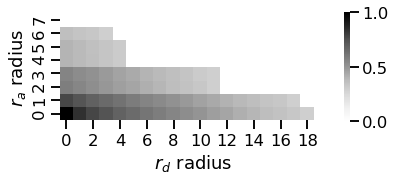

In [7]:
heatmap = (grid_binary_class>0.5).mean(0)
sns.set_context('talk')
sns.heatmap(heatmap, 
            cmap='Greys',
            vmin=0, vmax=1, square=True, cbar_kws={"shrink": .5})
plt.xlim(0, heatmap.shape[1])
plt.ylim(0, heatmap.shape[0])
plt.xlabel('$r_d$ radius')
plt.ylabel('$r_a$ radius')
plt.show()

# Example certificate for discrete data

In [8]:
# generate toy data, replace this with actual samples from your model
np.random.seed(0)
n_instances = 1000
pre_votes = np.random.multinomial(n=n_samples_eval, pvals=[0.001, 0.001, 0.998], size=n_instances)
votes = np.random.multinomial(n=n_samples_eval, pvals=[0.001, 0.001, 0.998], size=n_instances)

In [9]:
# compute the lower bound on the probability of the majority class
p_lower = p_lower_from_votes(votes=votes, pre_votes=pre_votes, alpha=conf_alpha, n_samples=n_samples_eval)

In [10]:
# if pf_plus = pf_minus any combination of ra+rd+rc=r gives the same result.
pf_plus = pf_minus = 0.8
ra = 6
rd = 0
rc = 0

n_discrete_categories = 256

regions = regions_discrete(ra=ra, rd=rd, rc=rc, k=n_discrete_categories, pf_plus=pf_plus, pf_minus=pf_minus)

percent_robust = (compute_rho_for_many(regions=regions, p_emps=p_lower)>0.5).mean() * 100

print(f'At radius r={ra+rd+rc}, {percent_robust} percent of nodes are certifiably robust')

At radius r=6, 92.0 percent of nodes are certifiably robust
